Постановка задачи:
$$\underset{x \in S}{min} \; f(x) = \frac{1}{2} (x, Ax) + (b, x)$$
$$S = \{ x \in \mathbb{R}^n : (x,x) = 1 \}$$

In [1]:
import numpy as np
from scipy import linalg
from matplotlib import pyplot as plt
%matplotlib inline

Далее определим матрицу $A$, вектор-стоблец $b$, размерность пространства (автоматически из размерности $A$)

In [2]:
A = np.array([[1., 0., 2.], [0., 2., 1.], [2., 1., 5.]])
b = np.array([-1., -1., -1.])
print A
print b
n = A.shape[0]

[[ 1.  0.  2.]
 [ 0.  2.  1.]
 [ 2.  1.  5.]]
[-1. -1. -1.]


In [3]:
def F(x):
    return 0.5 * x.dot(np.dot(A, x)) + np.dot(b,x)

\begin{equation} 
\begin{aligned}
G_0 = Ax_0 + b - x_0(Ax_0 + b)^T x_0& \\
H_0 = - G_0& \\
\end{aligned}
\end{equation}

For k = 0, 1, ...
\begin{equation}
\begin{aligned}
\underset{t}{min}\;& \frac{1}{2} x_k(t)^T A x_k(t) + b^T x_k(t) \\
x_k(t) &= x_k M(t) + Q N(t) \\
\widehat{A} &= x_k^T H_k \\ 
\left(
\begin{array}{c}
M(t) \\
N(t)
\end{array}
\right) &= \exp{ t \left(
\begin{array}{cc}
\widehat{A} &  -R^T \\
R & 0
\end{array}
\right)}
\left(
\begin{array}{c}
1 \\
0
\end{array}
\right) \\
t_k &= t_{min}, \; x_{k+1} = x_k(t_k) 
\end{aligned}
\end{equation}

\begin{equation}
\begin{aligned}
G_{k+1}= &Ax_{k+1} + b - x_{k+1} (Ax_{k+1} + b)^T x_{k+1} \\ 
Parallel\;& transport\; H_k\; to\; x_{k+1}: \\
&\tau H_k = H_k M(t_k) - x_k R^T N(t_k) \\ 
&\tau G_k = G_k \\
&H_{k+1} = -G_{k+1} + \gamma_k \tau H_k, \; where \\
&\gamma_k = \frac{\big< G_{k+1} - \tau G_{k}, G_{k+1}\big>}{\big< G_k, G_k\big>} \; and \\
&\big<\Delta_1, \Delta_2 \big> = tr\Delta_1^T (I - \frac{1}{2}) x x^T )\Delta_2 \\
&Reset \; H_{k+1} = -G_{k+1} \; if \; k+1 = 0\; mod\; n-1
\end{aligned}
\end{equation}

Где $QR$ - $QR$ разложение матрицы $(I - x_k x_k ^ T)H_k $

In [16]:
x0 = np.array([1., 1., 1.])
x0 = x0 / np.linalg.norm(x0)
G0 = A.dot(x0) + b - x0*(np.dot(A.dot(x0) + b, x0))
H0 = - G0

In [17]:
def backtracking_line_search(f, gradf, tau): # attention! this is for scalar function of one varianle
    alpha = 10.
    c = 1e-4
    ro = 0.5
    i = 0
    print 'BLS DEBUG:'
    print 'tau = ', tau
    print 'first arg = ', tau - alpha * gradf(tau)
    print 'gradf(tau) = ', gradf(tau)
    print 'f(tau) = ', f(tau)
    while(f(tau - alpha * gradf(tau)) < (f(tau) -  c * alpha * gradf(tau) * gradf(tau))):
        alpha = ro * alpha
        if i % 10 == 0:
            print 'BLS iteration number: ', i
        #print 'alpha_i = ', alpha
        i += 1
    return alpha

In [18]:
def armijoRule(f, gradf, tau):
    alpha = 0.9
    eps = 0.9
    ro = 0.5
    i = 0
    print 'ARMIJO DEBUG:'
    print 'tau = ', tau
    print 'first arg = ', tau - alpha * gradf(tau)
    print 'gradf(tau) = ', gradf(tau)
    print 'f(tau) = ', f(tau)
    while (f(tau - alpha * gradf(tau)) - f(tau) > - eps * alpha * gradf(tau) * gradf(tau)) and (i < 100):
        if i % 10 == 0:
            print 'Armijo iteration number: ', i
        alpha = alpha * ro
        i += 1
    return alpha

In [19]:
def GetNewMN(x, H, Q, R, A, b, t0 = 0):
    #QR dec of vector is Q = unit vector and R is its norm
    Ahat = x.dot(H)
    #toBeQRed = (np.eye(len(x)) - np.dot(x.reshape(len(x), 1),x.reshape(1, len(x)))).dot(H)
    #Q = toBeQRed / np.linalg.norm(toBeQRed)
    #R = np.linalg.norm(toBeQRed)
    #print 'GetNewT DEBUG: '
    #print 'x shape = ', x.shape
    underExp = np.array([[Ahat, -R], [R, 0]])
    expm = lambda t: linalg.expm(t * underExp)
    M = lambda t: expm(t)[0][0]
    N = lambda t: expm(t)[1][0]
    gradMinT = lambda t: (x * M(t) + Q * N(t)).dot(np.dot(A, x * (underExp.dot(expm(t)))[0][0] + Q * (underExp.dot(expm(t)))[1][0])) + np.dot(b, x * (underExp.dot(expm(t)))[0][0] + Q * (underExp.dot(expm(t)))[1][0]) 
    MinT = lambda t: 0.5 * np.dot((x * M(t) + Q * N(t)), A.dot(x * M(t) + Q * N(t))) + b.dot(x * M(t) + Q * N(t))
    tk = t0
    #print 'gradMinT(1) = ', gradMinT(1)
    #print 'underExp.dot(expm(t))[0][0] = ', underExp.dot(expm(10.))[0][0]
    #print 'gradMinT shape  = ', gradMinT(tk).shape
    #print 'backtracking line search shape = ', len(backtracking_line_search(MinT, gradMinT, tk))
    #tkk = tk + backtracking_line_search(MinT, gradMinT, tk) * gradMinT(tk)
    tkk = tk - armijoRule(MinT, gradMinT, tk) * gradMinT(tk)
    j = 0
    print 'GetNewMN before while: tk = ', tk
    print 'GetNewMN before while: tkk = ', tkk
    while (np.abs(tk - tkk) > 1e-2):
        print 'GetNewMN while iter num = ', j
        tk = tkk
        print 'GetNewMN in while: tk = ', tk
        print 'GetNewMN in while: MinT = ', MinT(tk)
        print 'GetNewMN in while: MinT arg: '
        print (x * expm(tk)[0][0] + Q * expm(tk)[1][0])
        tkk = tk - armijoRule(MinT, gradMinT, tk) * gradMinT(tk)
        j += 1
    print tkk
    return M(tkk), N(tkk)
        
    

In [20]:
def innerProd(x, y, Y):
    return np.trace( np.atleast_2d(np.dot(x, np.dot(np.eye(Y.shape[0]) - 0.5 * np.dot(Y, np.atleast_2d(Y).T), y))))

In [24]:
def StiefelCGM(x0, A, b, xs, fs, eps = 1e-4, iter_num = 48):
    xk = x0 / np.linalg.norm(x0)
    Gk = A.dot(xk) + b - xk*(np.dot(A.dot(xk) + b, xk))
    Hk = - Gk
    toBeQRed = (np.eye(len(xk)) - np.atleast_2d(xk).dot(np.atleast_2d(xk).T)).dot(Hk)
    Q = toBeQRed / np.linalg.norm(toBeQRed)
    R = np.linalg.norm(toBeQRed)
    #xtk = lambda t: xk * expm(t)[0][0] + Q * expm(t)[1][0]
    tk = 0.
    for i in range(iter_num):
        print 'METHOD DEBUG in FOR iter num = ', i
        Mtk, Ntk = GetNewMN(xk, Hk, Q, R, A, b)
        print 'Mtk = ', Mtk
        print 'Ntk = ', Ntk
        xk = xk * Mtk + Q * Ntk
        toBeQRed = (np.eye(len(xk)) - np.atleast_2d(xk).dot(np.atleast_2d(xk).T)).dot(Hk)
        Q = toBeQRed / np.linalg.norm(toBeQRed)
        R = np.linalg.norm(toBeQRed)
        print 'xk = ', xk
        print 'xk.norm = ', np.linalg.norm(xk)
        tauGk = Gk
        Gk = A.dot(xk) + b - xk * np.dot((A.dot(xk) + b), xk)
        tauHk = Hk * Mtk - xk * R * Ntk
        #set tauGk = 0
        gammak = innerProd(Gk , Gk, xk) / innerProd(tauGk, tauGk, xk)
        Hk = -Gk + gammak * tauHk
        if ((i + 1) % (n- 1)) == 0:
            Hk = -Gk
        print 'F(xk) = ', F(xk)
        xs.append(xk) 
        fs.append(F(xk))
    return xk

        
        

In [22]:
x0 = np.random.randn(3)
x0 = np.array( x0 / np.linalg.norm(x0))
print x0
#x0 = np.array([1., 0.,  0.])

[-0.02922722  0.49361609 -0.86918866]


[-0.02922722  0.49361609 -0.86918866]

In [25]:
xs = []
fs = []
ans = StiefelCGM(x0, A, b, xs, fs, iter_num=12)
print ans

METHOD DEBUG in FOR iter num =  0
ARMIJO DEBUG:
tau =  0
first arg =  -38.234195914
gradf(tau) =  42.4824399044
f(tau) =  2.15936851186
Armijo iteration number:  0
GetNewMN before while: tk =  0
GetNewMN before while: tkk =  -0.0373380819473
GetNewMN while iter num =  0
GetNewMN in while: tk =  -0.0373380819473
GetNewMN in while: MinT =  0.702122070351
GetNewMN in while: MinT arg: 
[ 0.13104899  0.62414862 -0.62854503]
ARMIJO DEBUG:
tau =  -0.0373380819473
first arg =  -30.4826421237
gradf(tau) =  33.828115602
f(tau) =  0.702122070351
Armijo iteration number:  0
Armijo iteration number:  10
GetNewMN while iter num =  1
GetNewMN in while: tk =  -0.0522039530614
GetNewMN in while: MinT =  0.242588400741
GetNewMN in while: MinT arg: 
[ 0.19232974  0.6607809  -0.51536024]
ARMIJO DEBUG:
tau =  -0.0522039530614
first arg =  -25.0712868481
gradf(tau) =  27.7989809944
f(tau) =  0.242588400741
Armijo iteration number:  0
Armijo iteration number:  10
-0.0583121275963
Mtk =  0.890038742086
Ntk = 

Armijo iteration number:  0
GetNewMN before while: tk =  0
GetNewMN before while: tkk =  0.00498343675083
0.00498343675083
Mtk =  0.993082167989
Ntk =  0.0145222277436
xk =  [ 0.60098668  0.93593112 -0.11694397]
xk.norm =  1.11840419832
F(xk) =  -0.579239577168
METHOD DEBUG in FOR iter num =  8
ARMIJO DEBUG:
tau =  0
first arg =  3.67596724022
gradf(tau) =  -4.08440804469
f(tau) =  -0.579239577168
Armijo iteration number:  0
GetNewMN before while: tk =  0
GetNewMN before while: tkk =  0.0143592470321
GetNewMN while iter num =  0
GetNewMN in while: tk =  0.0143592470321
GetNewMN in while: MinT =  -0.634811222543
GetNewMN in while: MinT arg: 
[ 0.63005719  0.87996754 -0.11423891]
ARMIJO DEBUG:
tau =  0.0143592470321
first arg =  3.29229570767
gradf(tau) =  -3.64215162293
f(tau) =  -0.634811222543
Armijo iteration number:  0
GetNewMN while iter num =  1
GetNewMN in while: tk =  0.0271636863315
GetNewMN in while: MinT =  -0.678554334751
GetNewMN in while: MinT arg: 
[ 0.65392534  0.8271058

In [27]:
print ans
print F(ans)
print np.linalg.norm(ans)

[ 1.0968435   0.51564463 -0.22041901]
-1.00037374999
1.23188457204


In [28]:
print fs

[0.081224158500525556, 0.032084389946399838, -0.14497099168328842, -0.19199483551836705, -0.34034456981096872, -0.3435635085289962, -0.56584782809773215, -0.57923957716823093, -0.73572029853151766, -0.9972474610053087, -0.99821357541377853, -1.0003737499924166]


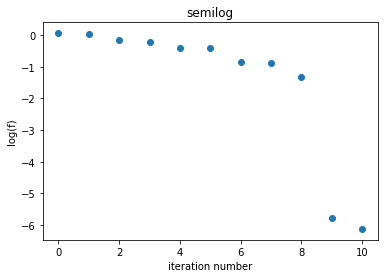

In [29]:
fstar = fs[np.argmin(fs)]
fminfstar = fs - np.ones(len(fs)) * fstar
logf = np.log(fminfstar[:len(fs) - 1])

plt.figure()
plt.scatter(range(len(logf)), logf)
plt.xlabel('iteration number')
plt.ylabel('log(f)')
plt.title('semilog')
plt.show()

In [30]:
x0 = np.random.randn(3)
x0 = np.array( x0 / np.linalg.norm(x0))
print x0
#x0 = np.array([1., 0.,  0.])

[ 0.7007404  -0.00212934 -0.71341317]


[ 0.7007404  -0.00212934 -0.71341317]

In [31]:
xs = []
fs = []
ans = StiefelCGM(x0, A, b, xs, fs, iter_num=12)
print ans

METHOD DEBUG in FOR iter num =  0
ARMIJO DEBUG:
tau =  0
first arg =  -25.8796487161
gradf(tau) =  28.7551652401
f(tau) =  0.53440530115
Armijo iteration number:  0
Armijo iteration number:  10
GetNewMN before while: tk =  0
GetNewMN before while: tkk =  -0.0126365472247
GetNewMN while iter num =  0
GetNewMN in while: tk =  -0.0126365472247
GetNewMN in while: MinT =  0.188470901067
GetNewMN in while: MinT arg: 
[ 0.74960093  0.05945679 -0.65735162]
ARMIJO DEBUG:
tau =  -0.0126365472247
first arg =  -23.3113963161
gradf(tau) =  25.8875108543
f(tau) =  0.188470901067
Armijo iteration number:  0
Armijo iteration number:  10
GetNewMN while iter num =  1
GetNewMN in while: tk =  -0.0240128947681
GetNewMN in while: MinT =  -0.0888476502681
GetNewMN in while: MinT arg: 
[ 0.7876298   0.11444379 -0.60162905]
ARMIJO DEBUG:
tau =  -0.0240128947681
first arg =  -20.5373708983
gradf(tau) =  22.7926200039
f(tau) =  -0.0888476502681
Armijo iteration number:  0
Armijo iteration number:  10
GetNewMN w

GetNewMN while iter num =  4
GetNewMN in while: tk =  -0.22474088664
GetNewMN in while: MinT =  -1.04466016237
GetNewMN in while: MinT arg: 
[ 1.15506721  0.44901399 -0.34339985]
ARMIJO DEBUG:
tau =  -0.22474088664
first arg =  -0.290646578268
gradf(tau) =  0.0732285462526
f(tau) =  -1.04466016237
Armijo iteration number:  0
GetNewMN while iter num =  5
GetNewMN in while: tk =  -0.241217309547
GetNewMN in while: MinT =  -1.04580294882
GetNewMN in while: MinT arg: 
[ 1.1583994   0.44722421 -0.34859497]
ARMIJO DEBUG:
tau =  -0.241217309547
first arg =  -0.300132929511
gradf(tau) =  0.0654617999598
f(tau) =  -1.04580294882
Armijo iteration number:  0
GetNewMN while iter num =  6
GetNewMN in while: tk =  -0.255946214538
GetNewMN in while: MinT =  -1.04671513009
GetNewMN in while: MinT arg: 
[ 1.16135656  0.44559945 -0.35325501]
ARMIJO DEBUG:
tau =  -0.255946214538
first arg =  -0.30848714606
gradf(tau) =  0.0583788128017
f(tau) =  -1.04671513009
Armijo iteration number:  0
GetNewMN while i

In [32]:
print ans
print F(ans)
print np.linalg.norm(ans)

[ 1.30683996  0.50533816 -0.40405715]
-1.15094507598
1.45823849458


In [33]:
print fs

[-0.4610974759718941, -0.57163755498268298, -0.79078736179228182, -0.88540285706498956, -0.91329904630065939, -1.011193128961575, -1.0173534418683006, -1.0175277445924951, -1.0488200031254782, -1.1057870288012777, -1.1105561374333142, -1.150945075982416]


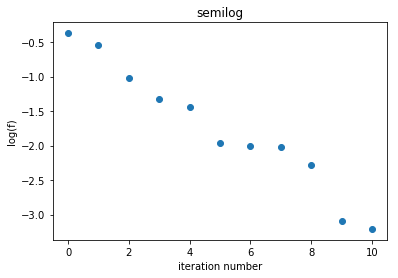

In [34]:
fstar = fs[np.argmin(fs)]
fminfstar = fs - np.ones(len(fs)) * fstar
logf = np.log(fminfstar[:len(fs) - 1])

plt.figure()
plt.scatter(range(len(logf)), logf)
plt.xlabel('iteration number')
plt.ylabel('log(f)')
plt.title('semilog')
plt.show()

In [35]:
x0 = np.random.randn(3)
x0 = np.array( x0 / np.linalg.norm(x0))
print x0
#x0 = np.array([1., 0.,  0.])

[ 0.27194413 -0.81888149  0.5054498 ]


[ 0.27194413 -0.81888149  0.5054498 ]

In [36]:
xs = []
fs = []
ans = StiefelCGM(x0, A, b, xs, fs, iter_num=12)
print ans

METHOD DEBUG in FOR iter num =  0
ARMIJO DEBUG:
tau =  0
first arg =  -0.119479502526
gradf(tau) =  0.132755002806
f(tau) =  1.24873473
Armijo iteration number:  0
GetNewMN before while: tk =  0
GetNewMN before while: tkk =  -0.0149349378157
GetNewMN while iter num =  0
GetNewMN in while: tk =  -0.0149349378157
GetNewMN in while: MinT =  1.2468822411
GetNewMN in while: MinT arg: 
[ 0.27357867 -0.81325613  0.51298675]
ARMIJO DEBUG:
tau =  -0.0149349378157
first arg =  -0.11875635422
gradf(tau) =  0.115357129338
f(tau) =  1.2468822411
Armijo iteration number:  0
GetNewMN while iter num =  1
GetNewMN in while: tk =  -0.0279126148663
GetNewMN in while: MinT =  1.245482256
GetNewMN in while: MinT arg: 
[ 0.27497876 -0.80830781  0.51949804]
ARMIJO DEBUG:
tau =  -0.0279126148663
first arg =  -0.118294940071
gradf(tau) =  0.100424805783
f(tau) =  1.245482256
Armijo iteration number:  0
GetNewMN while iter num =  2
GetNewMN in while: tk =  -0.0392104055169
GetNewMN in while: MinT =  1.244420424

GetNewMN while iter num =  4
GetNewMN in while: tk =  -0.0766215400737
GetNewMN in while: MinT =  1.15397590592
GetNewMN in while: MinT arg: 
[ 0.32007574 -0.82927722  0.37530457]
ARMIJO DEBUG:
tau =  -0.0766215400737
first arg =  -0.155735465891
gradf(tau) =  0.0879043620191
f(tau) =  1.15397590592
Armijo iteration number:  0
-0.0865107808008
Mtk =  1.01031735609
Ntk =  -0.0695354149166
xk =  [ 0.31799462 -0.82677444  0.38246737]
xk.norm =  0.964861568897
F(xk) =  1.15316282834
METHOD DEBUG in FOR iter num =  5
ARMIJO DEBUG:
tau =  0
first arg =  -0.688883160549
gradf(tau) =  0.765425733944
f(tau) =  1.15316282834
Armijo iteration number:  0
GetNewMN before while: tk =  0
GetNewMN before while: tkk =  -0.0107637993836
GetNewMN while iter num =  0
GetNewMN in while: tk =  -0.0107637993836
GetNewMN in while: MinT =  1.14546446772
GetNewMN in while: MinT arg: 
[ 0.32621934 -0.8183993   0.39597294]
ARMIJO DEBUG:
tau =  -0.0107637993836
first arg =  -0.609410751657
gradf(tau) =  0.66516328

In [37]:
print ans
print F(ans)
print np.linalg.norm(ans)

[-0.17469673  1.00672609  0.03654576]
0.18754347744
1.02242455


In [38]:
print fs

[1.243612487393875, 1.2386577620495316, 1.2381158579281104, 1.1641098243634793, 1.1531628283406987, 1.1396466430697485, 1.1372911950208033, 1.1144819772102859, 0.19430921138288237, 0.19416549271513395, 0.1899151429027639, 0.18754347743987487]


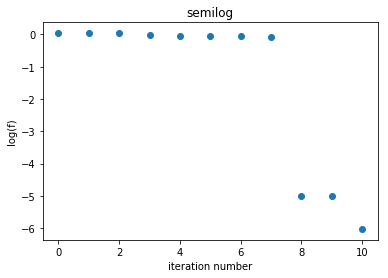

In [39]:
fstar = fs[np.argmin(fs)]
fminfstar = fs - np.ones(len(fs)) * fstar
logf = np.log(fminfstar[:len(fs) - 1])

plt.figure()
plt.scatter(range(len(logf)), logf)
plt.xlabel('iteration number')
plt.ylabel('log(f)')
plt.title('semilog')
plt.show()

In [41]:
x0 = np.random.randn(3)
x0 = np.array( x0 / np.linalg.norm(x0))
print x0
#x0 = np.array([1., 0.,  0.])

[-0.06582394  0.98440237 -0.16315389]


[-0.06582394  0.98440237 -0.16315389]

In [42]:
xs = []
fs = []
ans = StiefelCGM(x0, A, b, xs, fs, iter_num=12)
print ans

METHOD DEBUG in FOR iter num =  0
ARMIJO DEBUG:
tau =  0
first arg =  -1.0722308759
gradf(tau) =  1.19136763989
f(tau) =  0.143207646889
Armijo iteration number:  0
GetNewMN before while: tk =  0
GetNewMN before while: tkk =  -0.00837680371795
-0.00837680371795
Mtk =  0.999723243846
Ntk =  -0.0235252144361
xk =  [-0.05732103  1.00185854 -0.1501804 ]
xk.norm =  1.01467254735
F(xk) =  0.134149118271
METHOD DEBUG in FOR iter num =  1
ARMIJO DEBUG:
tau =  0
first arg =  -0.998292961328
gradf(tau) =  1.10921440148
f(tau) =  0.134149118271
Armijo iteration number:  0
GetNewMN before while: tk =  0
GetNewMN before while: tkk =  -0.00779916376038
-0.00779916376038
Mtk =  0.998911625791
Ntk =  -0.0227913171193
xk =  [-0.04882384  1.0178059  -0.13744662]
xk.norm =  1.02820434991
F(xk) =  0.126341588745
METHOD DEBUG in FOR iter num =  2
ARMIJO DEBUG:
tau =  0
first arg =  -1.3595353307
gradf(tau) =  1.51059481188
f(tau) =  0.126341588745
Armijo iteration number:  0
GetNewMN before while: tk =  0


In [43]:
print ans
print F(ans)
print np.linalg.norm(ans)

[-0.02334826  1.0654126  -0.09287532]
0.113138543786
1.06970789635


In [44]:
print fs

[0.13414911827105946, 0.12634158874519075, 0.12266178394277372, 0.11919988567795625, 0.11795518528812665, 0.1161214403137083, 0.1157334121327338, 0.11460354263424311, 0.11451389695792957, 0.11373336284769608, 0.11372753837561222, 0.11313854378582977]


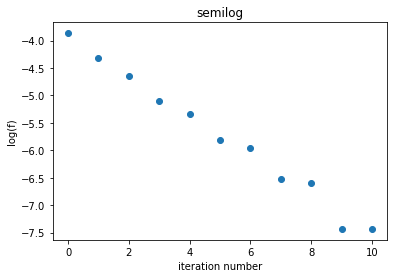

In [45]:
fstar = fs[np.argmin(fs)]
fminfstar = fs - np.ones(len(fs)) * fstar
logf = np.log(fminfstar[:len(fs) - 1])

plt.figure()
plt.scatter(range(len(logf)), logf)
plt.xlabel('iteration number')
plt.ylabel('log(f)')
plt.title('semilog')
plt.show()

In [49]:
x0 = np.random.randn(3)
x0 = np.array( x0 / np.linalg.norm(x0))
print x0
#x0 = np.array([1., 0.,  0.])

[-0.01270356 -0.32081693 -0.94705603]


[-0.01270356 -0.32081693 -0.94705603]

In [50]:
xs = []
fs = []
ans = StiefelCGM(x0, A, b, xs, fs, iter_num=12)
print ans

METHOD DEBUG in FOR iter num =  0
ARMIJO DEBUG:
tau =  0
first arg =  -24.8056819563
gradf(tau) =  27.5618688403
f(tau) =  3.95376207867
Armijo iteration number:  0
GetNewMN before while: tk =  0
GetNewMN before while: tkk =  -0.0968971951418
GetNewMN while iter num =  0
GetNewMN in while: tk =  -0.0968971951418
GetNewMN in while: MinT =  1.38884944985
GetNewMN in while: MinT arg: 
[ 0.01360016 -0.04679443 -0.55958107]
ARMIJO DEBUG:
tau =  -0.0968971951418
first arg =  -20.7985039798
gradf(tau) =  23.0017853163
f(tau) =  1.38884944985
Armijo iteration number:  0
GetNewMN while iter num =  1
GetNewMN in while: tk =  -0.117113608017
GetNewMN in while: MinT =  0.949262951321
GetNewMN in while: MinT arg: 
[ 0.01894777  0.01292217 -0.46464994]
ARMIJO DEBUG:
tau =  -0.117113608017
first arg =  -18.485856503
gradf(tau) =  20.4097143277
f(tau) =  0.949262951321
Armijo iteration number:  0
GetNewMN while iter num =  2
GetNewMN in while: tk =  -0.135051833501
GetNewMN in while: MinT =  0.6064924

gradf(tau) =  -0.121486986435
f(tau) =  -0.778081761311
Armijo iteration number:  0
GetNewMN before while: tk =  0
GetNewMN before while: tkk =  0.00170841074674
0.00170841074674
Mtk =  1.00005119342
Ntk =  0.00255333656155
xk =  [ 0.93022481  0.21398791 -0.18065112]
xk.norm =  0.971464797837
F(xk) =  -0.778274069485
METHOD DEBUG in FOR iter num =  7
ARMIJO DEBUG:
tau =  0
first arg =  0.0552927831112
gradf(tau) =  -0.0614364256791
f(tau) =  -0.778274069485
Armijo iteration number:  0
GetNewMN before while: tk =  0
GetNewMN before while: tkk =  0.00345579894445
0.00345579894445
Mtk =  1.00021567594
Ntk =  0.00257950093333
xk =  [ 0.92860572  0.21480925 -0.18234585]
xk.norm =  0.970413115713
F(xk) =  -0.778471170532
METHOD DEBUG in FOR iter num =  8
ARMIJO DEBUG:
tau =  0
first arg =  0.0352392860012
gradf(tau) =  -0.0391547622235
f(tau) =  -0.778471170532
Armijo iteration number:  0
GetNewMN before while: tk =  0
GetNewMN before while: tkk =  0.000550613843768
0.000550613843768
Mtk =  

In [51]:
print ans
print F(ans)
print np.linalg.norm(ans)

[ 0.9273209   0.21537831 -0.18364336]
-0.77853924485
0.969554924435


In [52]:
print fs

[-0.071900435372652879, -0.76302107141561382, -0.7775085615755517, -0.77757658877069891, -0.77761441277779653, -0.77808176131098983, -0.77827406948506339, -0.77847117053166126, -0.77849118312708632, -0.77852386284072872, -0.77852990652423415, -0.77853924485003412]


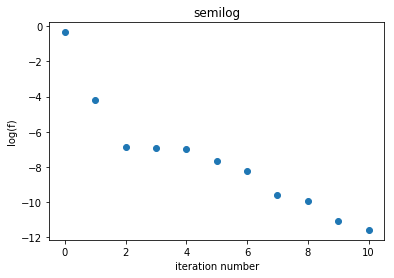

In [53]:
fstar = fs[np.argmin(fs)]
fminfstar = fs - np.ones(len(fs)) * fstar
logf = np.log(fminfstar[:len(fs) - 1])

plt.figure()
plt.scatter(range(len(logf)), logf)
plt.xlabel('iteration number')
plt.ylabel('log(f)')
plt.title('semilog')
plt.show()

In [54]:
x0 = np.random.randn(3)
x0 = np.array( x0 / np.linalg.norm(x0))
print x0
#x0 = np.array([1., 0.,  0.])

[-0.52356458 -0.84413289  0.1154114 ]


[-0.52356458 -0.84413289  0.1154114 ]

In [55]:
xs = []
fs = []
ans = StiefelCGM(x0, A, b, xs, fs, iter_num=12)
print ans

METHOD DEBUG in FOR iter num =  0
ARMIJO DEBUG:
tau =  0
first arg =  -10.1066933131
gradf(tau) =  11.2296592368
f(tau) =  1.91693261819
Armijo iteration number:  0
GetNewMN before while: tk =  0
GetNewMN before while: tkk =  -0.157917083018
GetNewMN while iter num =  0
GetNewMN in while: tk =  -0.157917083018
GetNewMN in while: MinT =  0.251615584383
GetNewMN in while: MinT arg: 
[ 0.01978093 -0.30708071  0.14308276]
ARMIJO DEBUG:
tau =  -0.157917083018
first arg =  -7.76971341085
gradf(tau) =  8.45755147537
f(tau) =  0.251615584383
Armijo iteration number:  0
GetNewMN while iter num =  1
GetNewMN in while: tk =  -0.187650662423
GetNewMN in while: MinT =  0.0185684068934
GetNewMN in while: MinT arg: 
[ 0.12792394 -0.18553912  0.14221742]
ARMIJO DEBUG:
tau =  -0.187650662423
first arg =  -6.6668004063
gradf(tau) =  7.19905527098
f(tau) =  0.0185684068934
Armijo iteration number:  0
GetNewMN while iter num =  2
GetNewMN in while: tk =  -0.21295984111
GetNewMN in while: MinT =  -0.149328

GetNewMN while iter num =  7
GetNewMN in while: tk =  0.173009074685
GetNewMN in while: MinT =  -0.760941057353
GetNewMN in while: MinT arg: 
[ 0.71096038  0.43507721 -0.25268077]
ARMIJO DEBUG:
tau =  0.173009074685
first arg =  0.334756439653
gradf(tau) =  -0.179719294409
f(tau) =  -0.760941057353
Armijo iteration number:  0
GetNewMN while iter num =  8
GetNewMN in while: tk =  0.183118284996
GetNewMN in while: MinT =  -0.762653615182
GetNewMN in while: MinT arg: 
[ 0.71512712  0.43940349 -0.26048472]
ARMIJO DEBUG:
tau =  0.183118284996
first arg =  0.326275989814
gradf(tau) =  -0.159064116465
f(tau) =  -0.762653615182
Armijo iteration number:  0
0.192065641547
Mtk =  1.03266588295
Ntk =  0.174668914938
xk =  [ 0.7187749   0.44321155 -0.26739008]
xk.norm =  0.885760292094
F(xk) =  -0.763994510309
METHOD DEBUG in FOR iter num =  3
ARMIJO DEBUG:
tau =  0
first arg =  0.419190200748
gradf(tau) =  -0.46576688972
f(tau) =  -0.763994510309
Armijo iteration number:  0
GetNewMN before while: 

In [56]:
print ans
print F(ans)
print np.linalg.norm(ans)

[ 1.71251715  1.16066386 -0.73105156]
-1.34492219111
2.19414948306


In [52]:
print fs

[-0.071900435372652879, -0.76302107141561382, -0.7775085615755517, -0.77757658877069891, -0.77761441277779653, -0.77808176131098983, -0.77827406948506339, -0.77847117053166126, -0.77849118312708632, -0.77852386284072872, -0.77852990652423415, -0.77853924485003412]


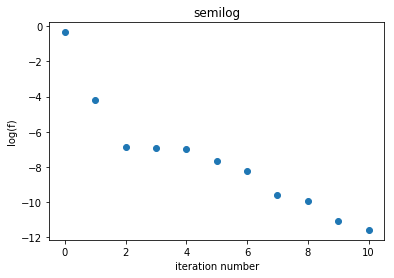

In [53]:
fstar = fs[np.argmin(fs)]
fminfstar = fs - np.ones(len(fs)) * fstar
logf = np.log(fminfstar[:len(fs) - 1])

plt.figure()
plt.scatter(range(len(logf)), logf)
plt.xlabel('iteration number')
plt.ylabel('log(f)')
plt.title('semilog')
plt.show()